# Importing libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
#reading file
df = pd.read_csv('grocery_sales_2015.csv',index_col= 'date', parse_dates=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 364 entries, 2015-01-01 to 2015-12-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unit_sales  364 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [6]:
#checking shape
df.shape

(364, 1)

In [7]:
#checking head
df.head()

,unit_sales
date,
2015-01-01,87.867550
2015-01-02,65.776339
2015-01-03,64.888069
2015-01-04,73.092378
2015-01-05,56.926730


# Data Preprocessing

In [8]:
#checking null values
df.isnull().sum() 

unit_sales    0
dtype: int64

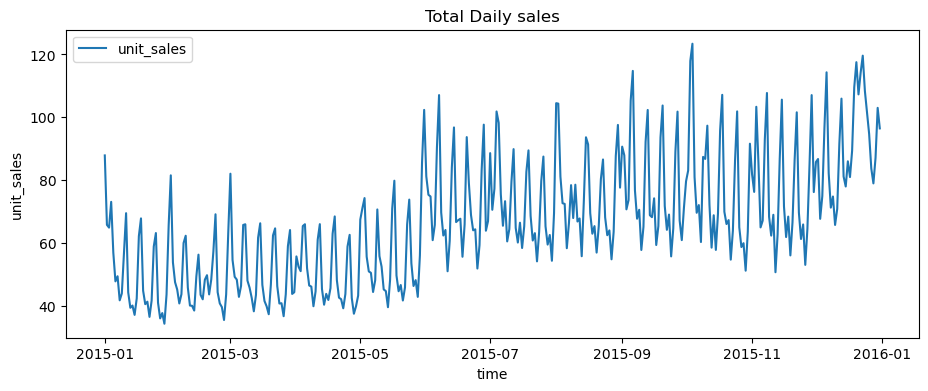

In [9]:
#plot to show the data distribution
plt.figure(figsize=(11, 4))

# Plot the data
plt.plot(df['unit_sales'], label='unit_sales',)

# Add labels and title
plt.xlabel('time')
plt.ylabel('unit_sales')
plt.title('Total Daily sales')
plt.legend()

# Show the plot
plt.show()

In [10]:
#split data into train and test
train = df.unit_sales[:334]
test = df.unit_sales[334:]
train.shape, test.shape

((334,), (30,))

# Test for Seasonality

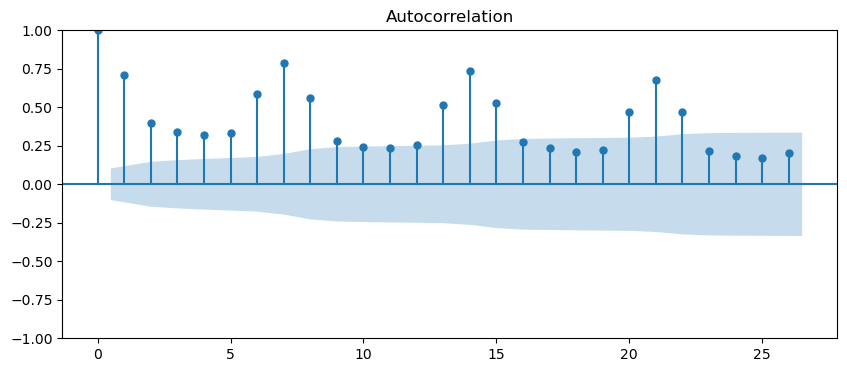

In [11]:
#checking autocorrelation
fig, ax = plt.subplots(figsize=(10,4))
plot_acf(df['unit_sales'], ax=ax)
plt.show()

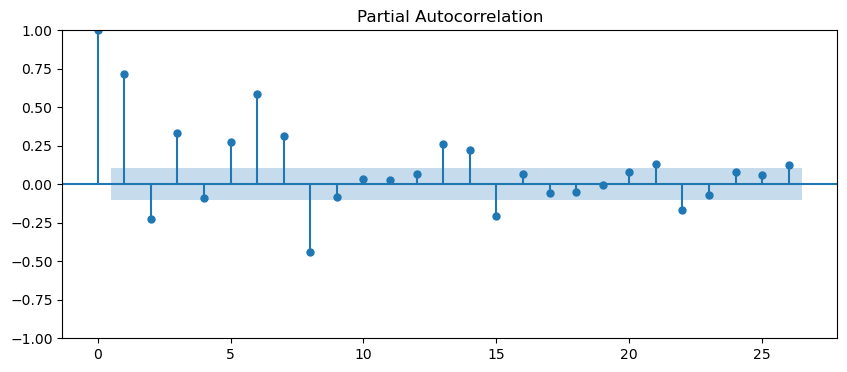

In [12]:
#checking partial autocorrelation
fig, ax = plt.subplots(figsize=(10,4))
plot_pacf(df['unit_sales'], ax=ax)
plt.show()

# Test for Stationarity 

In [13]:
#Augmented Dickey Fuller test
res = adfuller(df['unit_sales'])
print('t-value: ', res[0])
print('p-value: ', res[1])

t-value:  -0.36366593458508417
p-value:  0.9159908029124744


In [14]:
#since it is not stationary , differencing it
## d=1
df['diff1'] = df['unit_sales'].diff(periods= 1)
df = df.dropna()

In [15]:
res = adfuller(df['diff1'])
print('t-value: ', res[0])
print('p-value: ', res[1])

t-value:  -8.229439851478173
p-value:  6.119301015824496e-13


# Base Model

In [16]:
model = SARIMAX(train, order=(1,0,1), seasonal_order=(1,0,1,7), trend='c', )
results = model.fit()
results.summary()
#took seasonal as 7 because seasonality is repeating after every 7 months

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        unit_sales   No. Observations:                  334
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -1134.472
Date:                           Wed, 09 Aug 2023   AIC                           2280.944
Time:                                   20:59:19   BIC                           2303.811
Sample:                               01-01-2015   HQIC                          2290.061
                                    - 11-30-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3734      0.246      1.520      0.129      -0.108       0.855
ar.L1          0.6657      0.058     11.533      0.000       0.553       0.779
ma.L1          0.0473      0.066      0.716      0.474      -0.082       0.177
ar.S.L7        0.9826      0.010     98.329      0.000       0.963       1.002
ma.S.L7       -0.7575      0.048    -15.907      0.000      -0.851      -0.664
sigma2        51.7480      2.827     18.305      0.000      46.207      57.289
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               149.93
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                             0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
train_pred = results.predict(start=train.index[0], end=train.index[-1])
test_pred = results.forecast(test.shape[0])

print('RMSE - Train: ', np.sqrt(mean_squared_error(train, train_pred)))
print('RMSE - Test: ', np.sqrt(mean_squared_error(test, test_pred)))

RMSE - Train:  7.414267697483151
RMSE - Test:  22.8398595692571


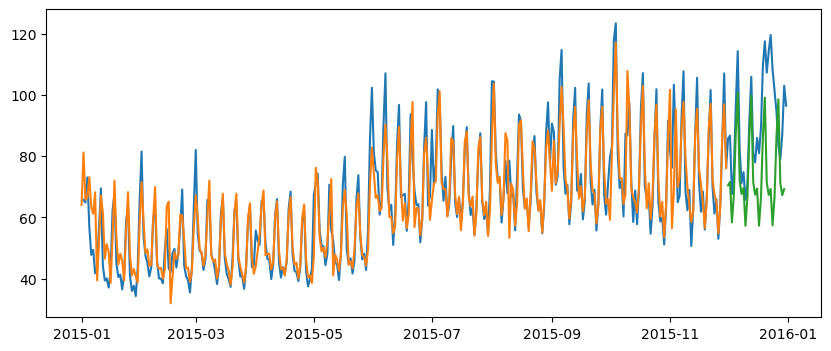

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(df['unit_sales'])
plt.plot(train_pred)
plt.plot(test_pred)
plt.show()

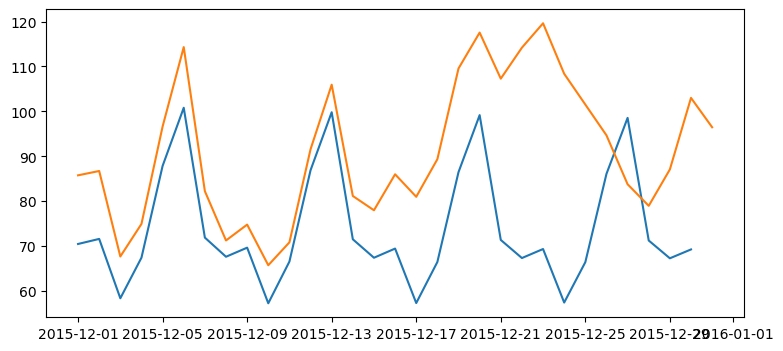

In [19]:
plt.figure(figsize=(9, 4))
plt.plot(test_pred)
plt.plot(test);

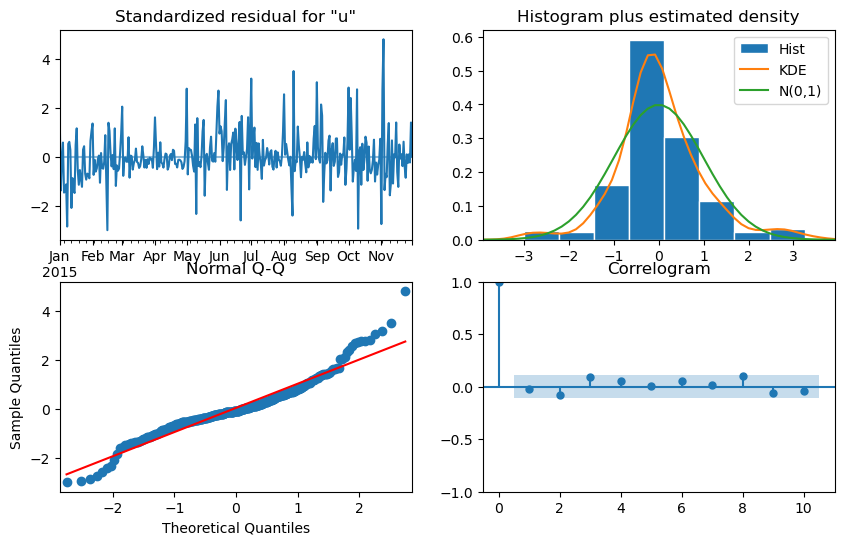

In [20]:
results.plot_diagnostics(figsize=(10, 6))
plt.show()

# AutoArima

In [21]:
from pmdarima import auto_arima

In [22]:
res = auto_arima(train,
    start_p=0,  d=None,     start_q=0,
    max_p=2,    max_d=2,    max_q=2,
    start_P=0,  D=None,     start_Q=0,
    max_P=2,    max_D=2,    max_Q=2,
    max_order=5, m=52, seasonal=True, trace=True, stepwise=True, random_state=42)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2742.713, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2745.326, Time=1.31 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2739.188, Time=1.51 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2740.714, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2737.806, Time=0.11 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2739.191, Time=1.18 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=2741.185, Time=2.37 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=2715.869, Time=0.15 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=2717.528, Time=1.75 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=2717.528, Time=1.65 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=2743.888, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=2589.906, Time=0.25 sec
 ARIMA(2,1,1)(1,0,0)[52] intercept   : AIC=2621.623, Time=2.21 sec
 ARIMA(2,1,1)(0,0,1)[52]

auto arima is giving ARIMA(2,1,2)(0,0,1) as best result

In [23]:
model = SARIMAX(train, order=(2,1,2), seasonal_order=(0,0,1,7), trend='c', )
results = model.fit()
results.summary()

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          unit_sales   No. Observations:                  334
Model:             SARIMAX(2, 1, 2)x(0, 0, [1], 7)   Log Likelihood               -1244.231
Date:                             Wed, 09 Aug 2023   AIC                           2502.462
Time:                                     21:01:15   BIC                           2529.119
Sample:                                 01-01-2015   HQIC                          2513.092
                                      - 11-30-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0600      0.047      1.281      0.200      -0.032       0.152
ar.L1          0.3078      0.154      1.998      0.046       0.006       0.610
ar.L2         -0.1126      0.106     -1.061      0.288      -0.320       0.095
ma.L1         -0.5452      0.140     -3.891      0.000      -0.820      -0.271
ma.L2         -0.4110      0.140     -2.942      0.003      -0.685      -0.137
ma.S.L7        0.4074      0.049      8.381      0.000       0.312       0.503
sigma2       102.0995      8.170     12.497      0.000      86.087     118.112
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 7.69
Prob(Q):                              0.92   Prob(JB):                         0.02
Heteroskedasticity (H):               2.46   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
train_pred = results.predict(start=train.index[0], end=train.index[-1])
test_pred = results.forecast(test.shape[0])

print('RMSE - Train: ', np.sqrt(mean_squared_error(train, train_pred)))
print('RMSE - Test: ', np.sqrt(mean_squared_error(test, test_pred)))

RMSE - Train:  11.23533146683478
RMSE - Test:  19.58107303374628


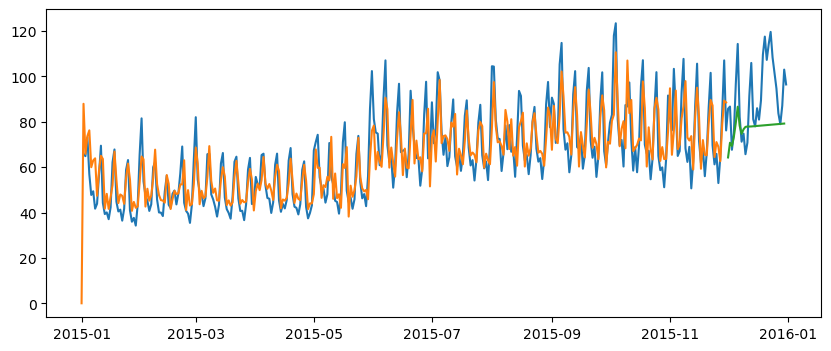

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(df['unit_sales'])
plt.plot(train_pred)
plt.plot(test_pred)
plt.show()

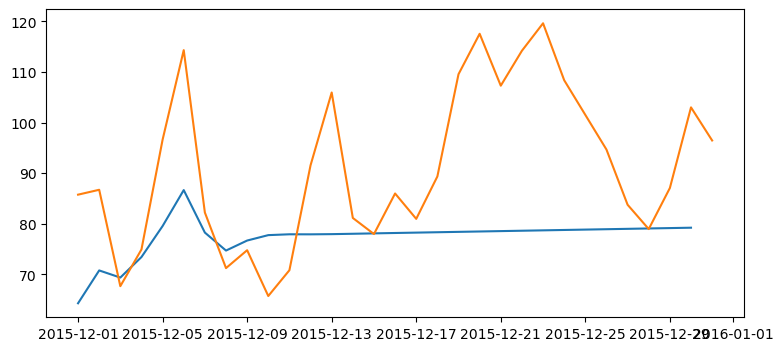

In [26]:
plt.figure(figsize=(9, 4))
plt.plot(test_pred)
plt.plot(test);

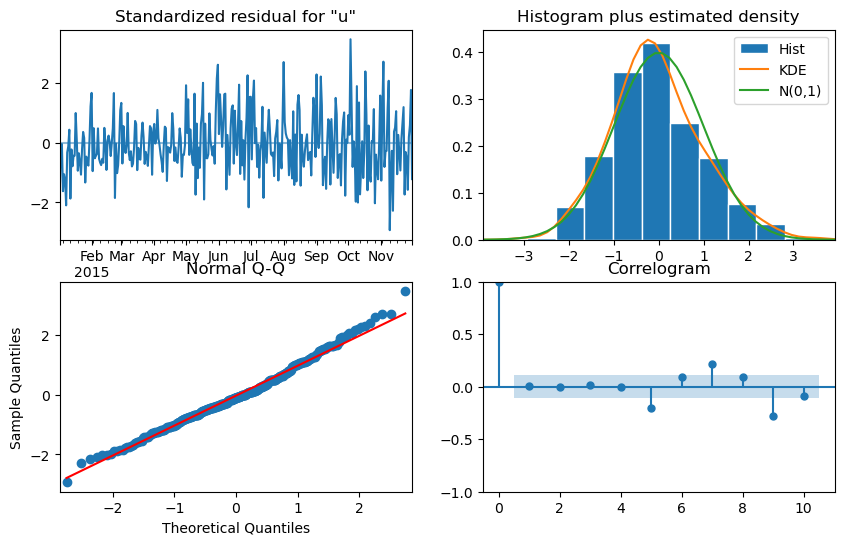

In [27]:
results.plot_diagnostics(figsize=(10, 6))
plt.show()

## Brute force method

In [28]:
from itertools import product
import statsmodels.api as sm

In [29]:
p_values = range(0, 2)  # AR order
d_values = [0]  # I order
q_values = range(0, 2)  # MA order
P_values = range(0, 2)  # Seasonal AR order
D_values = range(0, 2)  # Seasonal I order
Q_values = range(0, 2)  # Seasonal MA order
s_values = [7]         # Seasonal period 


param_combinations = list(product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))


best_params = None
best_rmse = np.inf


for params in param_combinations:
    p, d, q, P, D, Q, s = params

    # Fit the SARIMA model
    model = sm.tsa.SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
    results = model.fit()

    # Make predictions
    y_pred = results.forecast(test.shape[0])

    # Calculate RMSE (you can use other evaluation metrics if needed)
    rmse = np.sqrt(mean_squared_error(test, y_pred))

    # Update best parameters and RMSE if the current combination is better
    if rmse < best_rmse:
        best_params = params
        best_rmse = rmse


best_p, best_d, best_q, best_P, best_D, best_Q, best_s = best_params
best_params

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

(1, 0, 1, 0, 1, 1, 7)

In [30]:
final_model = sm.tsa.SARIMAX(train, order=(best_p, best_d, best_q), seasonal_order=(best_P, best_D, best_Q, best_s))
results = final_model.fit()
results.summary()

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        unit_sales   No. Observations:                  334
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -1105.419
Date:                           Wed, 09 Aug 2023   AIC                           2218.838
Time:                                   21:01:24   BIC                           2233.997
Sample:                               01-01-2015   HQIC                          2224.887
                                    - 11-30-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7601      0.051     14.983      0.000       0.661       0.860
ma.L1         -0.0738      0.061     -1.210      0.226      -0.193       0.046
ma.S.L7       -0.8213      0.033    -25.043      0.000      -0.886      -0.757
sigma2        49.2800      2.363     20.858      0.000      44.649      53.911
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):               260.23
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
train_pred = results.predict(start=train.index[0], end=train.index[-1])
test_pred = results.forecast(test.shape[0])

print('RMSE - Train: ', np.sqrt(mean_squared_error(train, train_pred)))
print('RMSE - Test: ', np.sqrt(mean_squared_error(test, test_pred)))

RMSE - Train:  11.924595836568653
RMSE - Test:  22.318469065185738


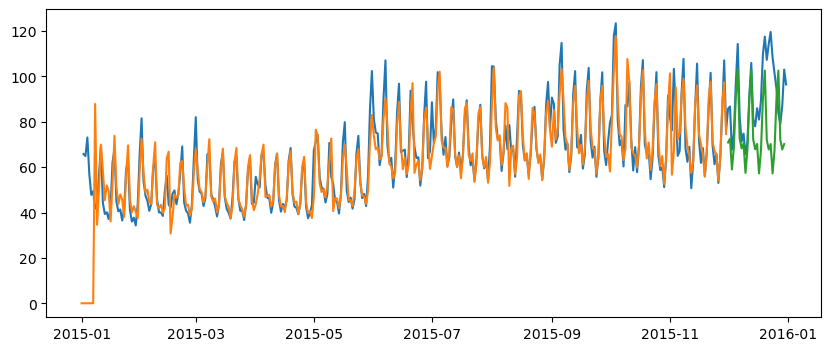

In [32]:
plt.figure(figsize=(10, 4))
plt.plot(df['unit_sales'])
plt.plot(train_pred)
plt.plot(test_pred)
plt.show()

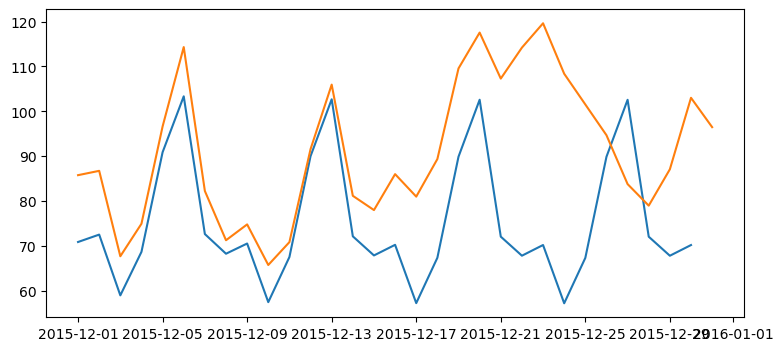

In [33]:
plt.figure(figsize=(9, 4))
plt.plot(test_pred)
plt.plot(test);

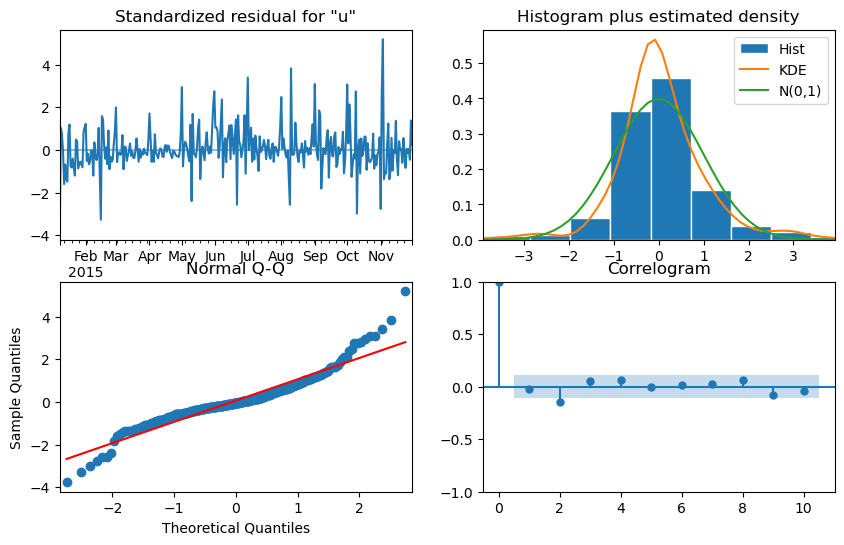

In [34]:
results.plot_diagnostics(figsize=(10, 6))
plt.show()

## New model

In [35]:
model = SARIMAX(train, order=(1,1,1), seasonal_order=(0,1,1,7), trend='c', )
results = model.fit()
results.summary()

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        unit_sales   No. Observations:                  334
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1100.907
Date:                           Wed, 09 Aug 2023   AIC                           2211.815
Time:                                   21:01:30   BIC                           2230.749
Sample:                               01-01-2015   HQIC                          2219.371
                                    - 11-30-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      0.004      0.436      0.663      -0.006       0.010
ar.L1          0.6142      0.049     12.466      0.000       0.518       0.711
ma.L1         -0.9393      0.030    -31.037      0.000      -0.999      -0.880
ma.S.L7       -0.8697      0.033    -26.143      0.000      -0.935      -0.805
sigma2        48.3385      2.977     16.239      0.000      42.504      54.173
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               168.74
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
train_pred = results.predict(start=train.index[0], end=train.index[-1])
test_pred = results.forecast(test.shape[0])

print('RMSE - Train: ', np.sqrt(mean_squared_error(train, train_pred)))
print('RMSE - Test: ', np.sqrt(mean_squared_error(test, test_pred)))

RMSE - Train:  9.15843812895061
RMSE - Test:  21.60554739490805


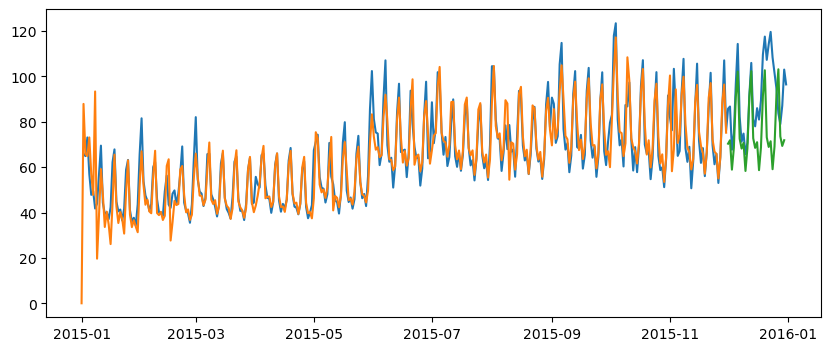

In [37]:
plt.figure(figsize=(10, 4))
plt.plot(df['unit_sales'])
plt.plot(train_pred)
plt.plot(test_pred)
plt.show()

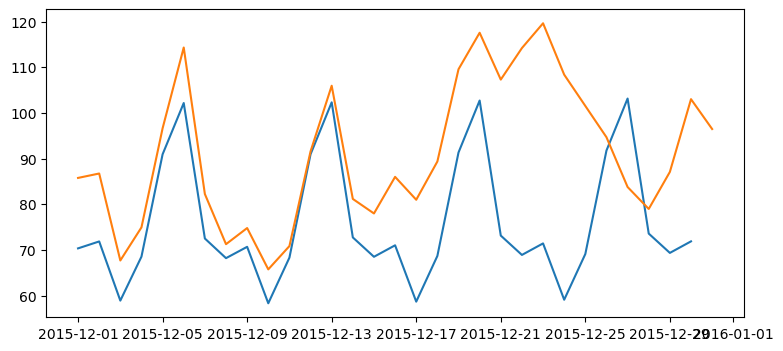

In [38]:
plt.figure(figsize=(9, 4))
plt.plot(test_pred)
plt.plot(test);

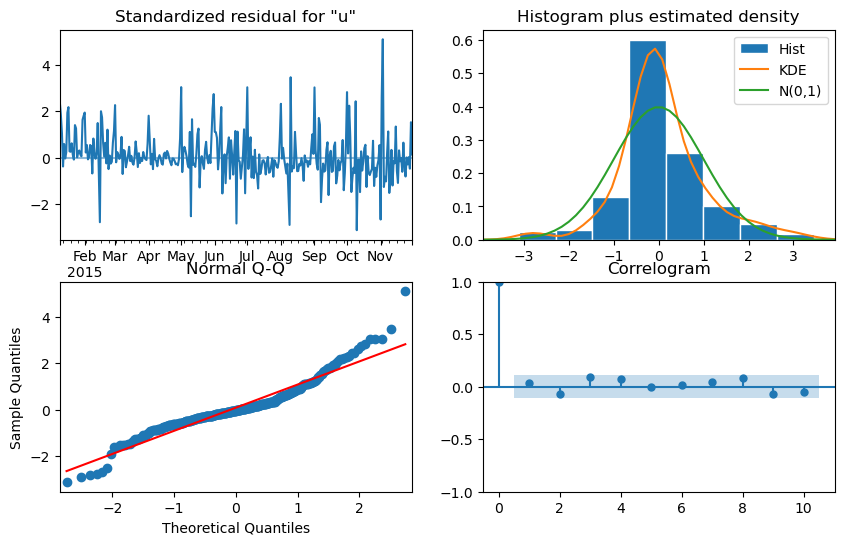

In [39]:
results.plot_diagnostics(figsize=(10, 6))
plt.show()

# Model Evaluation & Analysis

In [40]:
pd.DataFrame({'Indicators':['RMSE Train', 'RMSE Test','AIC', 'BIC','Jarque-Bera(JB)'],
              'Base (1,0,1)(1,0,1)':[7.418, 22.90, 2280.827, 2303.694, 150.74],
              'BruteForce (1,0,1)(0,1,1)':[11.92, 22.31,2218.838, 2233.997, 260.23],
              'Auto (2,1,2)(0,0,1)':[11.23,19.58, 2502.462, 2529.119, 7.69],
              'new(1,1,1)(0,0,1)':[9.15,21.60, 2211.815,2230.749,168.75]
             })

,Indicators,"Base (1,0,1)(1,0,1)","BruteForce (1,0,1)(0,1,1)","Auto (2,1,2)(0,0,1)","new(1,1,1)(0,0,1)"
0,RMSE Train,7.418,11.920,11.230,9.150
1,RMSE Test,22.900,22.310,19.580,21.600
2,AIC,2280.827,2218.838,2502.462,2211.815
3,BIC,2303.694,2233.997,2529.119,2230.749
4,Jarque-Bera(JB),150.740,260.230,7.690,168.750
